In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
import matplotlib.pyplot as plt
from LB_utils import * 

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

s = 127
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pytorch version:  1.5.0
cuda available:  True


# Load data

In [3]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

Files already downloaded and verified
Files already downloaded and verified


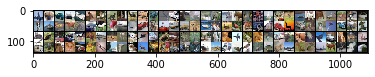

In [4]:
transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


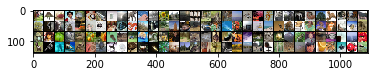

In [5]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


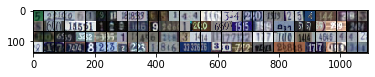

In [6]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, num_of_channels=3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.linear(out)
        return out

    def features(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18(num_of_channels=3, num_classes=10):
    if num_classes <= 2:
        num_classes = 1

    return ResNet(BasicBlock, [2,2,2,2],
                  num_of_channels=num_of_channels,
                  num_classes=num_classes)

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
CIFAR10_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [11]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [12]:
def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [13]:
# We know that you should not validate on your test data but our paper is not about the training process
# but rather about what you can do once you have a well-trained model. 

def train_all():
    CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_s{}.pth'.format(s)
    CIFAR10_PATH_BEST = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
    lr = 0.1
    epoch = 0
    for e in [30, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, CIFAR10_train_loader, CIFAR10_PATH)
            test(CIFAR10_model, epoch, CIFAR10_test_loader, save=True, path=CIFAR10_PATH_BEST)
            epoch += 1
        lr /= 10

In [14]:
#t0 = time.time()
#train_all()
#t1 = time.time()
#print("training took: {} seconds".format(t1-t0))

In [15]:
#training took: 4288.249864578247 seconds which is 71.47 minutes

In [16]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_pretrained.pth'
#CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0, CIFAR10_test_loader, save=False, path=CIFAR10_PATH)

loading model from: pretrained_weights/CIFAR10_resnet18_pretrained.pth
test loss:  14.309499010443687
current acc: 0.9542; best acc: 0


# prepare Gaussians (Diag and KFAC)

In [17]:
t0 = time.time()
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                                   train_loader=CIFAR10_train_loader,
                                                                   var0 = 1e-2,
                                                                   device=device)
t1 = time.time()
time_gaussian = t1-t0
print("preparing Gaussians took {} seconds which is {} minutes".format(time_gaussian, time_gaussian/60))

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68

In [18]:
#preparing Gaussians took 29.08268094062805 seconds which is 0.48471134901046753 minutes

In [19]:
M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K = KFLP_second_order(model=CIFAR10_model,
                                                               train_loader=CIFAR10_train_loader,
                                                               var0 = 2,
                                                               device=device)

Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68/391
Batch: 69/391
Batch: 70/391
Batch: 71/391
Ba

In [20]:
targets_CIFAR10 = CIFAR10_testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [21]:
#number of samples to draw from the Gaussian
num_samples = 1000

# MAP estimate

In [22]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, CIFAR10_test_loader, cuda=cuda_status).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=cuda_status).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, SVHN_test_loader, cuda=cuda_status).cpu().numpy()

In [23]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [24]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR10', 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'CIFAR10', 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.954; average entropy: 0.072;     MMC: 0.977; Prob @ correct: 0.100
[Out-CIFAR100, MAP, CIFAR10] Accuracy: 0.009; Average entropy: 0.547;    MMC: 0.811; AUROC: 0.879; Prob @ correct: 0.100
[Out-SVHN, MAP, CIFAR10] Accuracy: 0.092; Average entropy: 0.733;    MMC: 0.755; AUROC: 0.928; Prob @ correct: 0.100


In [25]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.954, 0.954, 0.954, 0.954, 0.954]
mmc_in = [0.977, 0.977, 0.977, 0.977, 0.977]
mmc_out_CIFAR100 = [0.811, 0.811, 0.811, 0.811, 0.811]
mmc_out_SVHN = [0.755, 0.755, 0.755, 0.755, 0.755]

auroc_out_CIFAR100 = [0.879, 0.879, 0.879, 0.879, 0.879]
auroc_out_SVHN = [0.928, 0.928, 0.928, 0.928, 0.928]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.954 with std 0.000
MMC in: 0.977 with std 0.000
MMC out CIFAR100: 0.811 with std 0.000
MMC out SVHN: 0.755 with std 0.000
AUROC out CIFAR100: 0.879 with std 0.000
AUROC out SVHN: 0.928 with std 0.000


# Diagonal estimate

In [26]:
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, cuda=False, timing=False):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum_fw = 0
        time_sum_mc = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        t0_fw = time.time()
        phi = model.features(x).detach()

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        t1_fw = time.time()

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        t0_mc = time.time()
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)
        t1_mc = time.time()
        if timing:
            time_sum_fw += (t1_fw - t0_fw)
            time_sum_mc += (t1_mc - t0_mc)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing: 
        print("time used for forward pass: {}".format(time_sum_fw))
        print("time used for sampling with {} samples: {}".format(n_samples, time_sum_mc))
    
    return torch.cat(py, dim=0)

In [27]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for forward pass: 0.6632184982299805
time used for sampling with 1000 samples: 13.039254903793335
time used for forward pass: 0.6622967720031738
time used for sampling with 1000 samples: 13.119536876678467
time used for forward pass: 1.54921555519104
time used for sampling with 1000 samples: 30.521629333496094


In [28]:
#timings for forward pass vs sampling as presented in the paper

fw_pass = np.array([0.4554176330566406, 0.44563722610473633, 0.44574522972106934, 0.44403839111328125, 0.44765353202819824])
mc_1000 = np.array([8.315938234329224, 8.18410873413086, 8.117920637130737, 8.08596658706665, 8.212565183639526])
mc_100 =  np.array([0.8649516105651855, 0.8614475727081299, 0.8721733093261719, 0.8692750930786133, 0.8676304817199707])
mc_10 =   np.array([0.11789608001708984, 0.11717033386230469, 0.11659884452819824, 0.11590909957885742, 0.11641597747802734])

print("forward pass timing: {:.03f} with std. {:.03f}".format(np.mean(fw_pass), np.std(fw_pass)))
print("mc 1000 timing: {:.03f} with std. {:.03f}".format(np.mean(mc_1000), np.std(mc_1000)))
print("mc 100 timing: {:.03f} with std. {:.03f}".format(np.mean(mc_100), np.std(mc_100)))
print("mc 10 timing: {:.03f} with std. {:.03f}".format(np.mean(mc_10), np.std(mc_10)))

fw_mc1000 = np.mean(fw_pass) + np.mean(mc_1000)
fw_mc100 = np.mean(fw_pass) + np.mean(mc_100)
fw_mc10 = np.mean(fw_pass) + np.mean(mc_10)
print("percentage forward: {:.03f} vs mc 1000: {:.03f}".format(np.mean(fw_pass)/fw_mc1000, np.mean(mc_1000)/fw_mc1000))
print("percentage forward: {:.03f} vs mc 100: {:.03f}".format(np.mean(fw_pass)/fw_mc100, np.mean(mc_100)/fw_mc100))
print("percentage forward: {:.03f} vs mc 10: {:.03f}".format(np.mean(fw_pass)/fw_mc10, np.mean(mc_10)/fw_mc10))

forward pass timing: 0.448 with std. 0.004
mc 1000 timing: 8.183 with std. 0.080
mc 100 timing: 0.867 with std. 0.004
mc 10 timing: 0.117 with std. 0.001
percentage forward: 0.052 vs mc 1000: 0.948
percentage forward: 0.341 vs mc 100: 0.659
percentage forward: 0.793 vs mc 10: 0.207


In [29]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [30]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR10', 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'CIFAR10', 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.954; average entropy: 0.080;     MMC: 0.975; Prob @ correct: 0.100
[Out-CIFAR100, Diag, CIFAR10] Accuracy: 0.009; Average entropy: 0.581;    MMC: 0.798; AUROC: 0.880; Prob @ correct: 0.100
[Out-SVHN, Diag, CIFAR10] Accuracy: 0.092; Average entropy: 0.771;    MMC: 0.741; AUROC: 0.928; Prob @ correct: 0.100


In [31]:
#Diag Sampling with 1000 samples as presented in the main paper
#seeds are 123,124,125,126,127
time_lpb_in = [6.6971423625946045, 6.527644395828247, 6.597438812255859, 6.5087058544158936, 6.581128835678101]
time_lpb_out_CIFAR100 = [6.678761959075928, 6.576663494110107, 6.6211583614349365, 6.486044645309448, 6.526758193969727]
time_lpb_out_SVHN = [17.291815280914307, 16.949442863464355, 17.131528854370117, 16.811217546463013, 16.7869553565979
]

acc_in = [0.955, 0.954, 0.954, 0.954, 0.954]
mmc_in = [0.948, 0.948, 0.948, 0.948, 0.948]
mmc_out_CIFAR100 = [0.708, 0.708, 0.708, 0.708, 0.708]
mmc_out_SVHN = [0.643, 0.643, 0.643, 0.643, 0.643]

auroc_out_CIFAR100 = [0.889, 0.889, 0.888, 0.889, 0.889]
auroc_out_SVHN = [0.933, 0.932, 0.933, 0.933, 0.933]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 6.582 with std 0.066
Sampling Bridge time out CIFAR100: 6.578 with std 0.068
Sampling Bridge time out SVHN: 16.994 with std 0.193
accuracy: 0.954 with std 0.000
MMC in: 0.948 with std 0.000
MMC out CIFAR100: 0.708 with std 0.000
MMC out SVHN: 0.643 with std 0.000
AUROC out CIFAR100: 0.889 with std 0.000
AUROC out SVHN: 0.933 with std 0.000


# KFAC estimate

In [33]:
CIFAR10_test_in_K = predict_KFAC_sampling(CIFAR10_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_K = predict_KFAC_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_K = predict_KFAC_sampling(CIFAR10_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 11.090741634368896
time used for sampling with 1000 samples: 11.142581939697266
time used for sampling with 1000 samples: 31.652571201324463


In [34]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(CIFAR10_test_in_K, targets_CIFAR10)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(CIFAR10_test_in_K, CIFAR10_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K = get_out_dist_values(CIFAR10_test_in_K, CIFAR10_test_out_SVHN_K, targets_SVHN)

In [35]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'CIFAR10', 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K, 'CIFAR10', 'SVHN', 'KFAC')

[In, KFAC, CIFAR10] Accuracy: 0.954; average entropy: 0.267;     MMC: 0.934; Prob @ correct: 0.100
[Out-CIFAR100, KFAC, CIFAR10] Accuracy: 0.009; Average entropy: 1.007;    MMC: 0.665; AUROC: 0.885; Prob @ correct: 0.100
[Out-SVHN, KFAC, CIFAR10] Accuracy: 0.092; Average entropy: 1.243;    MMC: 0.590; AUROC: 0.934; Prob @ correct: 0.100


In [36]:
#KFAC approximation of the Hessian with 1000 samples as presented in the main paper
#seeds are 123,124,125,126,127
time_lpb_in = [6.726973295211792, 6.580109119415283, 6.641083717346191, 6.549118518829346, 6.549356698989868]
time_lpb_out_CIFAR100 = [6.703295469284058, 6.578643083572388, 6.578174114227295, 6.478750705718994, 6.568273544311523]
time_lpb_out_SVHN = [17.26579451560974, 16.797159910202026, 17.12232232093811, 16.649921417236328, 16.981988191604614]


acc_in = [0.954, 0.954, 0.954, 0.954, 0.954]
mmc_in = [0.857, 0.860, 0.860, 0.852, 0.857]
mmc_out_CIFAR100 = [0.561, 0.565, 0.565, 0.557, 0.561]
mmc_out_SVHN = [0.484, 0.485, 0.489, 0.478, 0.484]


auroc_out_CIFAR100 = [0.886, 0.887, 0.885, 0.886, 0.885]
auroc_out_SVHN = [0.939, 0.939, 0.938, 0.940, 0.938]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 6.609 with std 0.068
Laplace Bridge time out CIFAR100: 6.581 with std 0.072
Laplace Bridge time out notmnist: 16.963 with std 0.220
accuracy: 0.954 with std 0.000
MMC in: 0.857 with std 0.003
MMC out CIFAR100: 0.562 with std 0.003
MMC out SVHN: 0.484 with std 0.004
AUROC out CIFAR100: 0.886 with std 0.001
AUROC out SVHN: 0.939 with std 0.001


# Laplace Bridge estimate

In [37]:
CIFAR10_test_in_LB = predict_LB(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB = predict_LB(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_LB = predict_LB(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

total time used for forward pass: 0.86208
total time used for Laplace Bridge: 0.03456
total time used for forward pass: 0.70963
total time used for Laplace Bridge: 0.02774
total time used for forward pass: 1.90970
total time used for Laplace Bridge: 0.07455


In [38]:
# timings for forward pass vs Laplace Bridge as presented in the main paper
time_lb = np.array([0.01397, 0.01397, 0.01405, 0.01389, 0.01402])

print("timing for Laplace Bridge: {:.03f} with std {:.03f}".format(np.mean(time_lb), np.std(time_lb)))

fw_lb = np.mean(fw_pass) + np.mean(time_lb)
print("percentage forward: {:.03f} vs lb: {:.03f}".format(np.mean(fw_pass)/fw_lb, np.mean(time_lb)/fw_lb))

timing for Laplace Bridge: 0.014 with std 0.000
percentage forward: 0.970 vs lb: 0.030


In [39]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_LBn = CIFAR10_test_in_LB/CIFAR10_test_in_LB.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_LBn = CIFAR10_test_out_CIFAR100_LB/CIFAR10_test_out_CIFAR100_LB.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_LBn = CIFAR10_test_out_SVHN_LB/CIFAR10_test_out_SVHN_LB.sum(1).reshape(-1,1)

In [40]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR10_test_in_LBn, targets_CIFAR10)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(CIFAR10_test_in_LBn, CIFAR10_test_out_CIFAR100_LBn, targets_CIFAR100)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR10_test_in_LBn, CIFAR10_test_out_SVHN_LBn, targets_SVHN)

In [41]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB, 'CIFAR10', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'CIFAR10', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR10] Accuracy: 0.954; average entropy: 0.140;     MMC: 0.966; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, CIFAR10] Accuracy: 0.009; Average entropy: 0.856;    MMC: 0.742; AUROC: 0.866; Prob @ correct: 0.100
[Out-SVHN, Laplace Bridge, CIFAR10] Accuracy: 0.092; Average entropy: 1.177;    MMC: 0.647; AUROC: 0.934; Prob @ correct: 0.100


In [42]:
#Laplace Bridge results as presented in the main paper
#seeds are 123,124,125,126,127
time_lpb_in = [0.01661, 0.01664, 0.01658, 0.01646, 0.01734]
time_lpb_out_CIFAR100 = [0.01575, 0.01610, 0.01561, 0.01592, 0.01615]
time_lpb_out_SVHN = [0.04018, 0.04055, 0.04020, 0.04041, 0.04276]


acc_in = [0.954, 0.954, 0.954, 0.954, 0.954]
mmc_in = [0.966, 0.966, 0.966, 0.966, 0.966]
mmc_out_CIFAR100 = [0.742, 0.742, 0.742, 0.742, 0.742]
mmc_out_SVHN = [0.647, 0.647, 0.647, 0.647, 0.647]

auroc_out_CIFAR100 = [0.866, 0.866, 0.866, 0.866, 0.866]
auroc_out_SVHN = [0.934, 0.934, 0.934, 0.934, 0.934]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.017 with std 0.000
Laplace Bridge time out CIFAR100: 0.016 with std 0.000
Laplace Bridge time out notmnist: 0.041 with std 0.001
accuracy: 0.954 with std 0.000
MMC in: 0.966 with std 0.000
MMC out CIFAR100: 0.742 with std 0.000
MMC out SVHN: 0.647 with std 0.000
AUROC out CIFAR100: 0.866 with std 0.000
AUROC out SVHN: 0.934 with std 0.000


# Laplace Bridge KFAC estimate

In [43]:
CIFAR10_test_in_LB_KFAC = predict_LB_KFAC(CIFAR10_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB_KFAC = predict_LB_KFAC(CIFAR10_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_LB_KFAC = predict_LB_KFAC(CIFAR10_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()

total time used for transform: 0.02535
total time used for transform: 0.03012
total time used for transform: 0.06282


In [44]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_LB_KFACn = CIFAR10_test_in_LB_KFAC/CIFAR10_test_in_LB_KFAC.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_LB_KFACn = CIFAR10_test_out_CIFAR100_LB_KFAC/CIFAR10_test_out_CIFAR100_LB_KFAC.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_LB_KFACn = CIFAR10_test_out_SVHN_LB_KFAC/CIFAR10_test_out_SVHN_LB_KFAC.sum(1).reshape(-1,1)

In [45]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(CIFAR10_test_in_LB_KFACn, targets_CIFAR10)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(CIFAR10_test_in_LB_KFACn, CIFAR10_test_out_CIFAR100_LB_KFACn, targets_CIFAR100)
acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC = get_out_dist_values(CIFAR10_test_in_LB_KFACn, CIFAR10_test_out_SVHN_LB_KFACn, targets_SVHN)

In [46]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'CIFAR10', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC, 'CIFAR10', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR10] Accuracy: 0.954; average entropy: 0.140;     MMC: 0.966; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, CIFAR10] Accuracy: 0.009; Average entropy: 0.855;    MMC: 0.742; AUROC: 0.866; Prob @ correct: 0.100
[Out-SVHN, Laplace Bridge, CIFAR10] Accuracy: 0.093; Average entropy: 1.170;    MMC: 0.650; AUROC: 0.933; Prob @ correct: 0.100


In [47]:
#Laplace Bridge KFAC results as presented in the main paper
#seeds are 123,124,125,126,127
time_lpb_in = [0.01866, 0.01882, 0.01865, 0.01834, 0.01876]
time_lpb_out_CIFAR100 = [0.01748, 0.01794, 0.01782, 0.01756, 0.01760]
time_lpb_out_SVHN = [0.04548, 0.04596, 0.04594, 0.04547, 0.04565]


acc_in = [0.954, 0.954, 0.954, 0.955, 0.954]
mmc_in = [0.966, 0.966, 0.966, 0.966, 0.966]
mmc_out_CIFAR100 = [0.742, 0.741, 0.741, 0.742, 0.741]
mmc_out_SVHN = [0.653, 0.645, 0.649, 0.648, 0.643]

auroc_out_CIFAR100 = [0.866, 0.867, 0.866, 0.866, 0.867]
auroc_out_SVHN = [0.932, 0.935, 0.933, 0.934, 0.936]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.019 with std 0.000
Laplace Bridge time out CIFAR100: 0.018 with std 0.000
Laplace Bridge time out notmnist: 0.046 with std 0.000
accuracy: 0.954 with std 0.000
MMC in: 0.966 with std 0.000
MMC out CIFAR100: 0.741 with std 0.000
MMC out SVHN: 0.648 with std 0.003
AUROC out CIFAR100: 0.866 with std 0.000
AUROC out SVHN: 0.934 with std 0.001


# Conditions

Test the condition derived in Proposition 1 of the paper and evaluated experimentally in Appendix A

In [48]:
# check if condition holds

def check_condition(alpha_vecs):
    #note that this is vectorized
    alpha_sum = alpha_vecs.sum(1)
    alpha_max = alpha_vecs.max(1)
    alpha_sum_minus = alpha_sum - alpha_max
    right_side = 0.25 * (np.sqrt(9 * alpha_sum_minus**2 + 10 * alpha_sum_minus + 1) - alpha_sum_minus - 1)
    cases = alpha_max > right_side
    percentage = np.sum(cases)/len(cases)
    return(percentage)

In [49]:
print(np.sum(check_condition(CIFAR10_test_in_LB)))
print(np.sum(check_condition(CIFAR10_test_out_CIFAR100_LB)))
print(np.sum(check_condition(CIFAR10_test_out_SVHN_LB)))

0.9979
0.9299
0.8418100799016595


In [50]:
condition_CIFAR10_in = np.array([0.9977, 0.9977, 0.9977, 0.9977, 0.9977])
condition_CIFAR100_out = np.array([0.925, 0.925, 0.925, 0.925, 0.925])
condition_SVHN_out = np.array([0.8322833435771358, 0.8322833435771358, 0.8322833435771358, 0.8322833435771358, 0.8322833435771358])

print("ratio condition fulfilled CIFAR10 in: {:.03f} with std: {}".format(np.mean(condition_CIFAR10_in), np.std(condition_CIFAR10_in)))
print("ratio condition fulfilled CIFAR100 out: {:.03f} with std: {}".format(np.mean(condition_CIFAR100_out), np.std(condition_CIFAR100_out)))
print("ratio condition fulfilled SVHN out: {:.03f} with std: {}".format(np.mean(condition_SVHN_out), np.std(condition_SVHN_out)))

ratio condition fulfilled CIFAR10 in: 0.998 with std: 0.0
ratio condition fulfilled CIFAR100 out: 0.925 with std: 0.0
ratio condition fulfilled SVHN out: 0.832 with std: 1.1102230246251565e-16


# Compare to extended MacKay approach

as detailed in Appendix D

In [51]:
CIFAR10_test_in_EMK = predict_extended_MacKay(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_EMK = predict_extended_MacKay(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_EMK = predict_extended_MacKay(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

time used for forward pass: 0.8553376197814941
time used for Extended MacKay Approach: 5.263708591461182
time used for forward pass: 0.7192447185516357
time used for Extended MacKay Approach: 3.7200324535369873
time used for forward pass: 1.9256739616394043
time used for Extended MacKay Approach: 9.614293813705444


In [52]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(CIFAR10_test_in_EMK, targets_CIFAR10)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(CIFAR10_test_in_EMK, CIFAR10_test_out_CIFAR100_EMK, targets_CIFAR100)
acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK = get_out_dist_values(CIFAR10_test_in_EMK, CIFAR10_test_out_SVHN_EMK, targets_SVHN)

In [53]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'CIFAR10', 'Extended MacKay')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR10', 'CIFAR100', 'Extended MacKay')
print_out_dist_values(acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK, 'CIFAR10', 'SVHN', 'Extended MacKay')

[In, Extended MacKay, CIFAR10] Accuracy: 0.954; average entropy: 0.081;     MMC: 0.975; Prob @ correct: 0.100
[Out-CIFAR100, Extended MacKay, CIFAR10] Accuracy: 0.009; Average entropy: 0.581;    MMC: 0.801; AUROC: 0.880; Prob @ correct: 0.100
[Out-SVHN, Extended MacKay, CIFAR10] Accuracy: 0.092; Average entropy: 0.771;    MMC: 0.744; AUROC: 0.929; Prob @ correct: 0.100


In [54]:
#Extended MacKay approach as presented in Appendix D
#seeds are 123,124,125,126,127
time_emk_in = [1.4817545413970947, 1.4886608123779297, 1.482903242111206, 1.4811437129974365, 1.4604389667510986]
time_emk_out_CIFAR100 = [1.5755081176757812, 1.4701554775238037, 1.547466516494751, 1.450073003768921, 1.461724042892456]
time_emk_out_SVHN = [3.8533170223236084, 3.8127734661102295, 3.8204636573791504, 3.7547571659088135, 3.902277708053589]


acc_in = [0.945, 0.945, 0.942, 0.945, 0.942]
mmc_in = [0.972, 0.971, 0.970, 0.970, 0.969]
mmc_out_CIFAR100 = [0.803, 0.805, 0.798, 0.797, 0.801]
mmc_out_SVHN = [0.778, 0.679, 0.726, 0.680, 0.709]

auroc_out_CIFAR100 = [0.876, 0.872, 0.873, 0.874, 0.870]
auroc_out_SVHN = [0.918, 0.950, 0.922, 0.939, 0.935]


print("Extended MacKay approach time in: {:.03f} with std {:.03f}".format(np.mean(time_emk_in), np.std(time_emk_in)))
print("Extended MacKay approach time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_emk_out_CIFAR100), np.std(time_emk_out_CIFAR100)))
print("Extended MacKay approach time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_emk_out_SVHN), np.std(time_emk_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Extended MacKay approach time in: 1.479 with std 0.010
Extended MacKay approach time out CIFAR100: 1.501 with std 0.051
Extended MacKay approach time out notmnist: 3.829 with std 0.049
accuracy: 0.944 with std 0.001
MMC in: 0.970 with std 0.001
MMC out CIFAR100: 0.801 with std 0.003
MMC out SVHN: 0.714 with std 0.036
AUROC out CIFAR100: 0.873 with std 0.002
AUROC out SVHN: 0.933 with std 0.012


# Compare to Second-order Delta Posterior Predictive

as detailed in Appendix D

In [55]:
CIFAR10_test_in_SODPP = predict_SODPP(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_SODPP = predict_SODPP(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_SODPP = predict_SODPP(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

time used for forward pass: 0.7208783626556396
time used for Second order delta posterior predictive: 0.04456305503845215
time used for forward pass: 0.7037391662597656
time used for Second order delta posterior predictive: 0.043274879455566406
time used for forward pass: 1.9783968925476074
time used for Second order delta posterior predictive: 0.12188029289245605


In [56]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(CIFAR10_test_in_SODPP, targets_CIFAR10)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP, CIFAR10_test_out_CIFAR100_SODPP, targets_CIFAR100)
acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP, CIFAR10_test_out_SVHN_SODPP, targets_SVHN)

In [57]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'CIFAR10', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP, 'CIFAR10', 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP, 'CIFAR10', 'SVHN', 'SODPP')

[In, SODPP, CIFAR10] Accuracy: 0.954; average entropy: 0.080;     MMC: 0.975; Prob @ correct: 0.100
[Out-CIFAR100, SODPP, CIFAR10] Accuracy: 0.009; Average entropy: 0.581;    MMC: 0.797; AUROC: 0.879; Prob @ correct: 0.100
[Out-SVHN, SODPP, CIFAR10] Accuracy: 0.092; Average entropy: 0.771;    MMC: 0.741; AUROC: 0.928; Prob @ correct: 0.100


In [58]:
#Second order delta posterior predictive as shown in Appendix D
#seeds are 123,124,125,126,127
time_sodpp_in = [0.024459123611450195, 0.02369832992553711, 0.024019241333007812, 0.023904085159301758, 0.024046659469604492]
time_sodpp_out_CIFAR100 = [0.023726463317871094, 0.02320384979248047, 0.023495197296142578, 0.02364373207092285, 0.022989273071289062]
time_sodpp_out_SVHN = [0.06233024597167969, 0.058495283126831055, 0.06014561653137207, 0.061838626861572266, 0.05889773368835449]


acc_in = [0.945, 0.946, 0.942, 0.945, 0.942]
mmc_in = [0.971, 0.971, 0.969, 0.969, 0.969]
mmc_out_CIFAR100 = [0.799, 0.801, 0.794, 0.773, 0.797]
mmc_out_SVHN = [0.773, 0.675, 0.722, 0.676, 0.705]

auroc_out_CIFAR100 = [0.875, 0.871, 0.872, 0.873, 0.870]
auroc_out_SVHN = [0.917, 0.949, 0.921, 0.939, 0.935]


print("SODPP time in: {:.03f} with std {:.03f}".format(np.mean(time_sodpp_in), np.std(time_sodpp_in)))
print("SODPP time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_sodpp_out_CIFAR100), np.std(time_sodpp_out_CIFAR100)))
print("SODPP time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_sodpp_out_SVHN), np.std(time_sodpp_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

SODPP time in: 0.024 with std 0.000
SODPP time out CIFAR100: 0.023 with std 0.000
SODPP time out notmnist: 0.060 with std 0.002
accuracy: 0.944 with std 0.002
MMC in: 0.970 with std 0.001
MMC out CIFAR100: 0.793 with std 0.010
MMC out SVHN: 0.710 with std 0.036
AUROC out CIFAR100: 0.872 with std 0.002
AUROC out SVHN: 0.932 with std 0.012
